In [1]:
import tensorflow as tf

# Allow GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU available.")

# Initialize GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


In [2]:
# We get the test set for landmarks and for masks.

import os
import cv2
import numpy as np
import tensorflow as tf

# Rutas a las carpetas de entrenamiento, prueba y validación para imágenes y máscaras
test_frames_dir = "./Frames/TEST"
test_Landmarks_dir = "./Landmarks/Landmarks/TEST"
test_masks_dir = "./Mascaras/Mask/TEST"

# Funciones para cargar y preprocesar imagen y máscara y convertirlo a solo un canal
def load_image(file_path):
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    return image

def load_landmarks(file_path):
    images = []
    for filename in os.listdir(file_path):
        image=cv2.imread(os.path.join(file_path, filename))
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(grayscale_image)

    stacked_image = np.stack(images, axis=-1)  # axis=-1 indica la dimensión de los canales
    stacked_image = stacked_image / 255.0
    return stacked_image

test_image_files = [os.path.join(test_frames_dir, filename) for filename in os.listdir(test_frames_dir)]
test_Landmarks_files = [os.path.join(test_Landmarks_dir, filename) for filename in os.listdir(test_Landmarks_dir)]
test_mask_files = [os.path.join(test_masks_dir, filename) for filename in os.listdir(test_masks_dir)]

test_images = [load_image(file) for file in test_image_files]
test_Landmarks = [load_landmarks(file) for file in test_Landmarks_files]
test_masks = [load_image(file) for file in test_mask_files]

test_images = np.array(test_images)
test_Landmarks = np.array(test_Landmarks)
test_masks = np.array(test_masks)

In [3]:
BATCH_SIZE = 16

with tf.device('CPU'):
    test_dataset_masks = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
    test_dataset_masks = test_dataset_masks.batch(BATCH_SIZE)

    test_dataset_Landmarks = tf.data.Dataset.from_tensor_slices((test_images, test_Landmarks))
    test_dataset_Landmarks = test_dataset_Landmarks.batch(BATCH_SIZE)

In [4]:
def accuracy_landmarks(y_true, y_pred):
    """
    Accuracy metric for 7 landmarks.
    Assumes y_true and y_pred are of shape (batch_size, 112, 112, 7).
    """
    # Extract the landmark values from y_true and y_pred
    y_true_landmarks = y_true[..., :7]
    y_pred_landmarks = y_pred[..., :7]

    # Calculate the element-wise absolute difference
    abs_diff = K.abs(y_true_landmarks - y_pred_landmarks)

    # Create a mask where each element is 1 if the absolute difference is less than a threshold, otherwise 0
    mask = K.cast(K.less(abs_diff, 0.5), dtype=tf.float32)

    # Calculate the accuracy for each landmark
    landmark_accuracy = K.mean(mask, axis=-1)

    # Overall accuracy is the mean accuracy across all landmarks
    overall_accuracy = K.mean(landmark_accuracy)

    return overall_accuracy

def dice_coefficient(y_true, y_pred):
    smooth = 1.0
    y_true_flat = tf.keras.backend.flatten(y_true)
    y_pred_flat = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_flat * y_pred_flat)
    return (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_flat) + tf.keras.backend.sum(y_pred_flat) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [5]:
# We get the model for the masks and the model for the landmarks.

landmarks_model_name = "landmark_20231124-180554"
masks_model_name = "mascara_20231122-180148"

path_landmarks = "./Pruebas/{}/model.h5".format(landmarks_model_name)
path_masks = "./Pruebas/{}/model.h5".format(masks_model_name)

# Generate a folder to save the plots that will be named comparacion + date and time
import datetime
import os
now = datetime.datetime.now()
date_time = now.strftime("%Y%m%d-%H%M%S")
path = "./Pruebas/Comparacion/comparacion_" + date_time
os.mkdir(path)

# Write on the result.txt file the model names
f = open(path + "/results.txt", "w")
f.write("Modelo de landmarks: {}\n".format(landmarks_model_name))
f.write("Modelo de máscaras: {}\n".format(masks_model_name))
f.write("Fecha y hora: {}\n".format(date_time))
f.write("-----------------------------------------------------------------\n")
f.close()

In [6]:
model_landmarks = tf.keras.models.load_model(path_landmarks,custom_objects={'accuracy_landmarks': accuracy_landmarks})
model_masks = tf.keras.models.load_model(path_masks, custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})

predictions_landmarks = model_landmarks.predict(test_dataset_Landmarks)
predictions_masks = model_masks.predict(test_dataset_masks)

160/160 [==============================] - 10s 63ms/step


In [7]:
from skimage.metrics import structural_similarity as ssim

#TODO: Investigate what the ssim function does
def calculate_ssim(image1, image2):
    # Calculate the Structural Similarity Index (SSI)
    similarity_index, _ = ssim(image1, image2, full=True, data_range=image1.max() - image1.min())

    # The SSI ranges from -1 to 1, where 1 indicates a perfect match
    # We normalize it to the range [0, 1] to represent percentage similarity
    percentage_similarity = (similarity_index + 1) / 2 * 100

    return percentage_similarity

In [8]:
# We plot 5 images with their respective landmarks and masks.

import matplotlib.pyplot as plt

# Function to visualize the images and masks

def visualize_predictions(images, landmarks, masks, landmarks_predictions, masks_predictions):
    num_images = len(images)
    string = ""
    for i in range(num_images):  # Renamed the inner loop variable to 'j'
        image = images[i]
        landmark = landmarks[i]
        mask = masks[i]
        landmark_prediction = landmarks_predictions[i]
        mask_prediction = masks_predictions[i]

        # Combine all channels of prediction_landmarks by taking the mean
        combined_prediction = np.mean(landmark_prediction, axis=-1)

        # CObine all channels of ground_truth_landmarks by taking the mean
        combined_ground_truth = np.mean(landmark, axis=-1)

        # Calculate the Structural Similarity Index (SSI) between the predicted and ground truth landmarks
        percentage_similarity_lm = calculate_ssim(combined_prediction, combined_ground_truth)

        # Calculate the mean absolute error between the predicted and ground truth landmarks
        mean_abs_error_lm = np.mean(np.abs(combined_prediction - combined_ground_truth))
        
        # Calculate the Structural Similarity Index (SSI) between the predicted and ground truth masks
        percentage_similarity_m = calculate_ssim(mask_prediction.reshape(112,112), mask.reshape(112,112))

        # Calculate the mean absolute error between the predicted and ground truth masks
        mean_abs_error_m = np.mean(np.abs(mask_prediction - mask))

        # Append to a string the percentage similarity and the mean absolute error for the landmarks and the masks and its image number
        string = string + "Image " + str(i) + ":\n" + "Landmarks: " + str(percentage_similarity_lm) + "% similarity, " + str(mean_abs_error_lm) + " mean absolute error\n" + "Masks: " + str(percentage_similarity_m) + "% similarity, " + str(mean_abs_error_m) + " mean absolute error\n"
        string = string + "\n"

        # Generate a plot with two rows and three columns, for image, ground truth landmarks, and predicted landmarks
        f, axarr = plt.subplots(2, 3, figsize=(20, 15))

        # Plot the image
        axarr[0, 0].imshow(image, cmap='gray')
        axarr[0, 0].set_title('Image')

        # Plot the ground truth landmarks
        axarr[0, 1].imshow(image, cmap='gray')
        axarr[0, 1].imshow(combined_ground_truth, alpha=0.5, cmap='jet')
        axarr[0, 1].set_title('Ground Truth Landmarks')

        # Plot the predicted landmarks
        axarr[0, 2].imshow(image, cmap='gray')
        axarr[0, 2].imshow(combined_prediction, alpha=0.5, cmap='jet')
        axarr[0, 2].set_title('Predicted Landmarks')

        # Plot the ground truth mask
        axarr[1, 0].imshow(image, cmap='gray')
        axarr[1, 0].imshow(mask, alpha=0.5, cmap='jet')
        axarr[1, 0].set_title('Ground Truth Mask')

        # Plot the predicted mask
        axarr[1, 1].imshow(image, cmap='gray')
        axarr[1, 1].imshow(mask_prediction, alpha=0.5, cmap='jet')
        axarr[1, 1].set_title('Predicted Mask')

        # Plot the predicted landmarks overlaid on the predicted mask
        axarr[1, 2].imshow(mask, alpha=0.5, cmap='grey')
        axarr[1, 2].imshow(combined_prediction, alpha=0.5, cmap='grey')
        axarr[1, 2].set_title('Predicted Landmarks & Ground Truth Mask')

        # Save the plot
        plt.savefig(path + "/plot_" + str(i) + ".png")
        plt.close()
    
    return string

num_samples_to_visualize = 5
sample_indices = np.random.choice(len(test_images[:10]), num_samples_to_visualize, replace=False)

sample_images = [test_images[i] for i in sample_indices]
sample_landmarks = [test_Landmarks[i] for i in sample_indices]
sample_masks = [test_masks[i] for i in sample_indices]
landmark_predictions = [predictions_landmarks[i] for i in sample_indices]
mask_predictions = [predictions_masks[i] for i in sample_indices]

# Visualize the predictions
string = visualize_predictions(sample_images, sample_landmarks, sample_masks, landmark_predictions, mask_predictions)

# Save string to a file
f = open(path + "/results.txt", "a")
f.write(string)
f.close()


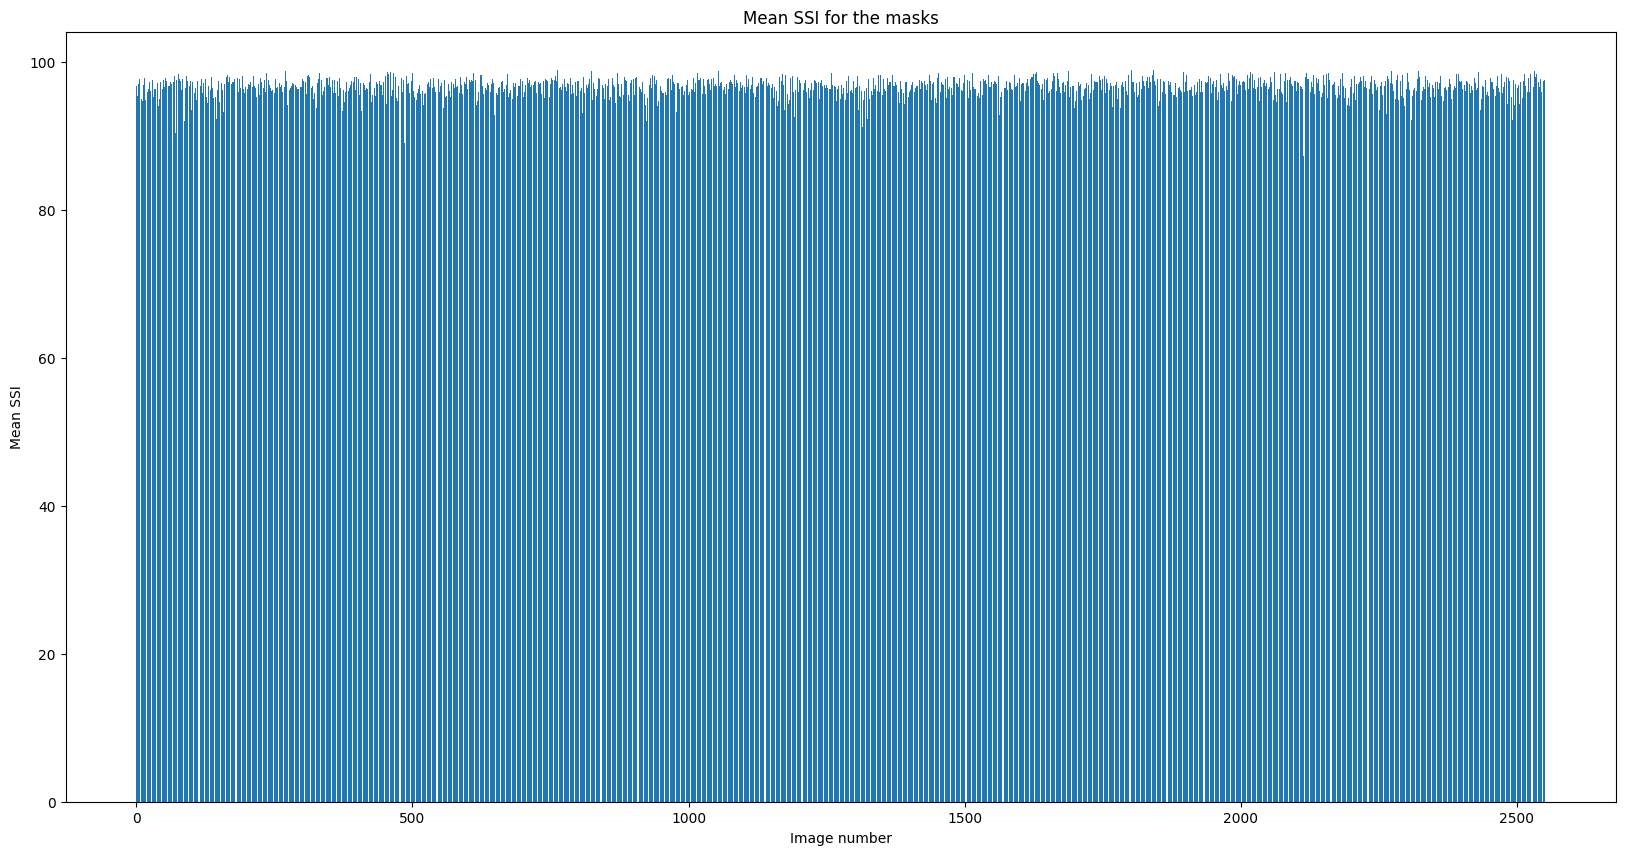

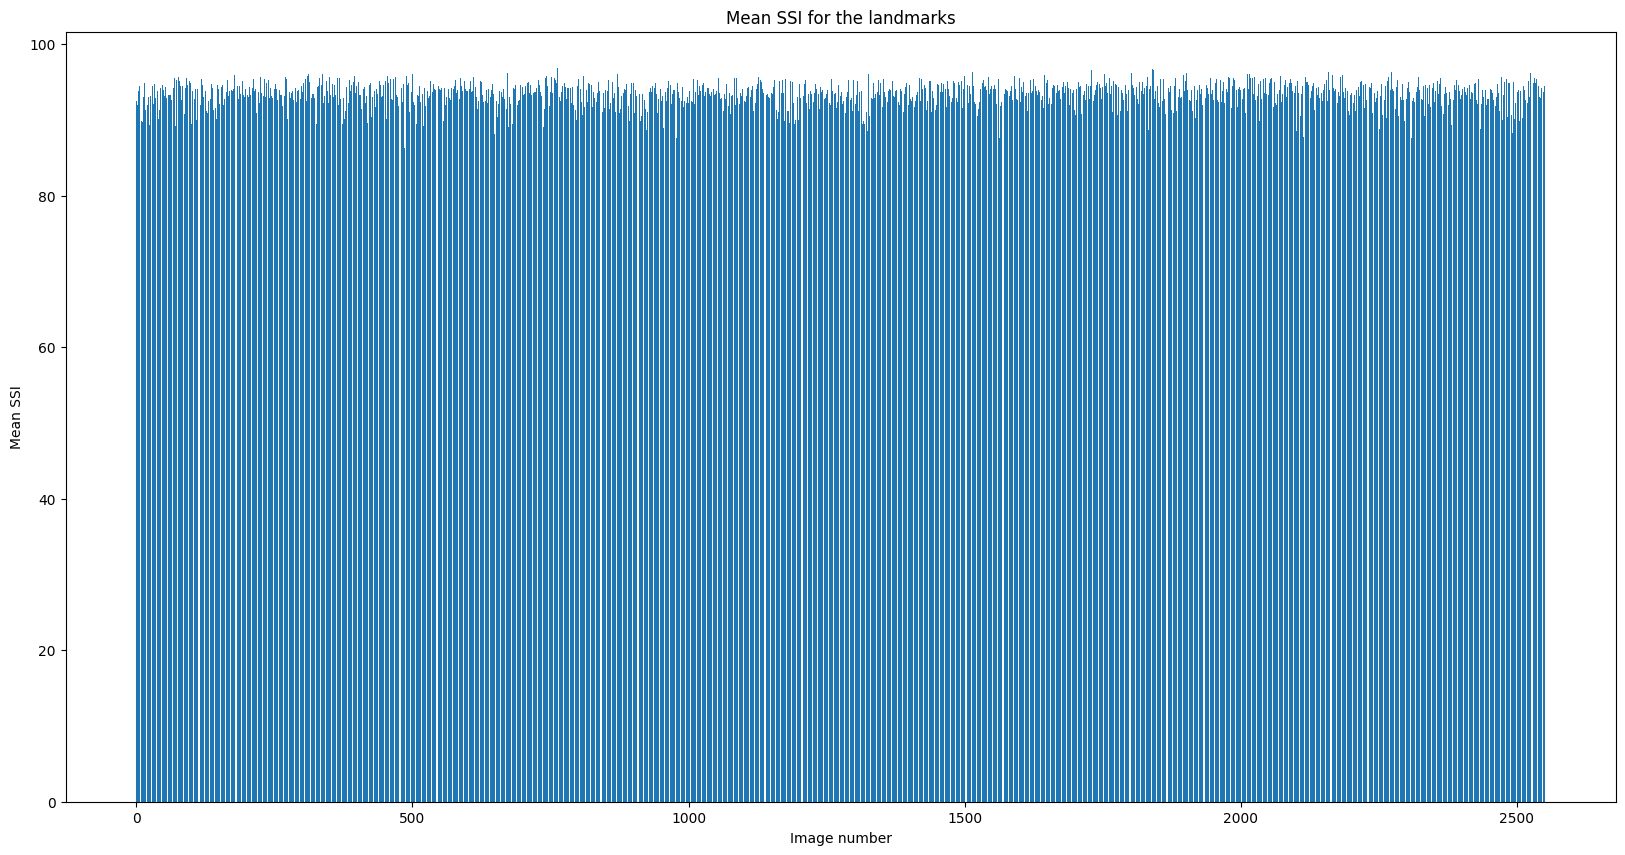

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate the mean Structural Similarity Index (SSI) for the masks in the test set
ssim_masks = []
for i in range(len(test_masks)):
    mask1 = test_masks[i].reshape(112,112)
    mask2 = predictions_masks[i].reshape(112,112)
    # We store the mean SSI for each mask in an array
    ssim_masks.append(calculate_ssim(mask1, mask2))

mean_ssim_mask = np.mean(ssim_masks)

# Calculate the mean Structural Similarity Index (SSI) for the landmarks in the test set
ssim_landmark = []
for i in range(len(test_Landmarks)):
    landmark1 = np.mean(test_Landmarks[i], axis=-1)
    landmark2 = np.mean(predictions_landmarks[i], axis=-1)
    # We store the mean SSI for each landmark in an array
    ssim_landmark.append(calculate_ssim(landmark1, landmark2))

# We calculate the mean of the mean SSI for all the landmarks
mean_ssim_landmark = np.mean(ssim_landmark)

# Calculate the mean absolute error for the landmarks in the test set
mean_abs_error_landmark = 0
for i in range(len(test_Landmarks)):
    landmark1 = np.mean(test_Landmarks[i], axis=-1)
    landmark2 = np.mean(predictions_landmarks[i], axis=-1)
    mean_abs_error_landmark += np.mean(np.abs(landmark1 - landmark2))

mean_abs_error_landmark /= len(test_Landmarks)

# Calculate the mean absolute error for the masks in the test set
mean_abs_error_mask = 0
for i in range(len(test_masks)):
    mask1 = test_masks[i].reshape(112,112)
    mask2 = predictions_masks[i].reshape(112,112)
    mean_abs_error_mask += np.mean(np.abs(mask1 - mask2))

mean_abs_error_mask /= len(test_masks)

# With the arrays of the mean SSI for each mask and landmark, we generate a histogram for each one.
plt.hist(ssim_masks, bins=10, color='blue', edgecolor='black')
plt.title("Mean SSI for Masks")
plt.savefig(path + "/histogram_mean_ssi_masks.png")
plt.close()

plt.hist(ssim_landmark, bins=10, color='blue', edgecolor='black')
plt.title("Mean SSI for Landmarks")
plt.savefig(path + "/histogram_mean_ssi_landmarks.png")
plt.close()

# Calculate which model is better and with what difference and save it to a file

if mean_ssim_mask > mean_ssim_landmark:
    string = "The model for the masks has a better mean ssim by " + str(mean_ssim_mask - mean_ssim_landmark) + "%"
else:
    string = "The model for the landmarks has a better mean ssim by " + str(mean_ssim_landmark - mean_ssim_mask) + "%"

if mean_abs_error_mask > mean_abs_error_landmark:
    string = string + "\nThe model for the landmarks has a better mean absolute error by " + str(mean_abs_error_mask - mean_abs_error_landmark)
else:
    string = string + "\nThe model for the masks has a better mean absolute error by " + str(mean_abs_error_landmark - mean_abs_error_mask)

# Save the mean SSI and mean absolute error to a file
f = open(path + "/results.txt", "a")
f.write("\n")
f.write("Mean SSI for Masks: " + str(mean_ssim_mask) + "\n")
f.write("Mean SSI for Landmarks: " + str(mean_ssim_landmark) + "\n")
f.write("Mean absolute error for Masks: " + str(mean_abs_error_mask) + "\n")
f.write("Mean absolute error for Landmarks: " + str(mean_abs_error_landmark) + "\n")
f.write("\n")
f.write(string)
f.close()



# We calculate the Dice Score for Landmarks

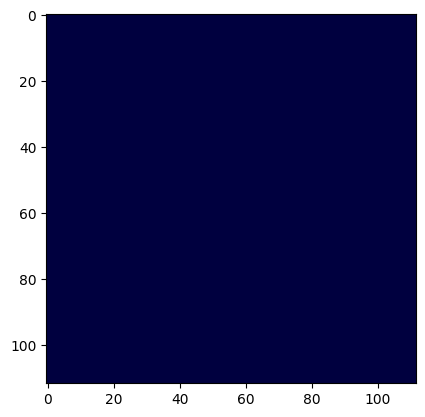

In [10]:
# We generate a mask from the landmarks and we calculate the mean absolute error and the mean SSI for the masks generated from the landmarks.

import numpy as np
import matplotlib.pyplot as plt

# Function to generate a mask from the landmarks
def generate_mask_from_landmarks(landmarks):
    # Combine all channels of landmarks by taking the mean
    combined_landmarks = np.mean(landmarks, axis=-1)

    # Threshold the image to create the mask
    mask = np.where(combined_landmarks > 0.5, 1.0, 0.0)

    return mask

# Plot a mask generated from the landmarks

plt.imshow(generate_mask_from_landmarks(test_Landmarks[0]), cmap='gray')
plt.imshow(generate_mask_from_landmarks(predictions_landmarks[0]), alpha=0.5, cmap='jet')
